In [1]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

c:\Users\MLAKSHMI\Pyworks\Trading\tradingvenv\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
nifty500 = pd.read_csv(r"C:\Users\MLAKSHMI\Pyworks\Trading\fundaanalysis\n500bsedf.csv")
nifty500_df = pd.read_csv(r"C:\Users\MLAKSHMI\Pyworks\Trading\nifty500.csv")
nifty500_df = nifty500_df[~(nifty500_df['yfin_ticker'] =="ADANITRANS.NS")]
nifty50 = pd.read_csv(r"C:\Users\MLAKSHMI\Pyworks\Trading\nifty50.csv")
nifty500 = pd.merge(nifty500, nifty500_df[["Symbol","yfin_ticker"]], left_on="Security Id", right_on = "Symbol", how='left')

In [3]:
from ema_trend import check_ema_trend
from consolidation import check_price_consolidation

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def ydata(ticker):
    data = yf.download(ticker, start = "2020-01-01", interval = '1d')
    data["Date"] = data.index
    data.index.names = ["Timestamp"]
    data["Date"] = data["Date"].apply(lambda x: x.strftime("%Y-%m-%d"))
    #data = data.reset_index()
    data['Date'] = data['Date'].astype('datetime64[s]')
    data = data[["Date","Open","High","Low","Close","Volume"]]
    return data

In [8]:
ydata(ticker)

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
Timestamp,,,,,,
2021-01-29 00:00:00+05:30,2021-01-29,24.900000,25.799999,24.350000,24.799999,381938573
2021-02-01 00:00:00+05:30,2021-02-01,25.250000,25.400000,24.900000,25.100000,72044464
2021-02-02 00:00:00+05:30,2021-02-02,25.450001,25.450001,24.700001,24.750000,36735442
2021-02-03 00:00:00+05:30,2021-02-03,24.799999,24.900000,24.049999,24.250000,45816269
2021-02-04 00:00:00+05:30,2021-02-04,24.250000,25.799999,23.850000,25.350000,88486029
...,...,...,...,...,...,...
2024-02-27 00:00:00+05:30,2024-02-27,152.899994,156.649994,151.000000,151.600006,43995103
2024-02-28 00:00:00+05:30,2024-02-28,152.850006,153.399994,145.500000,147.399994,39947465
2024-02-29 00:00:00+05:30,2024-02-29,146.000000,150.250000,140.800003,146.750000,63490121


[*********************100%***********************]  1 of 1 completed
0.7201499287967494 0.5311553507319667 0.41617668958674786
EMAs are in an upward direction for the last 6 months.


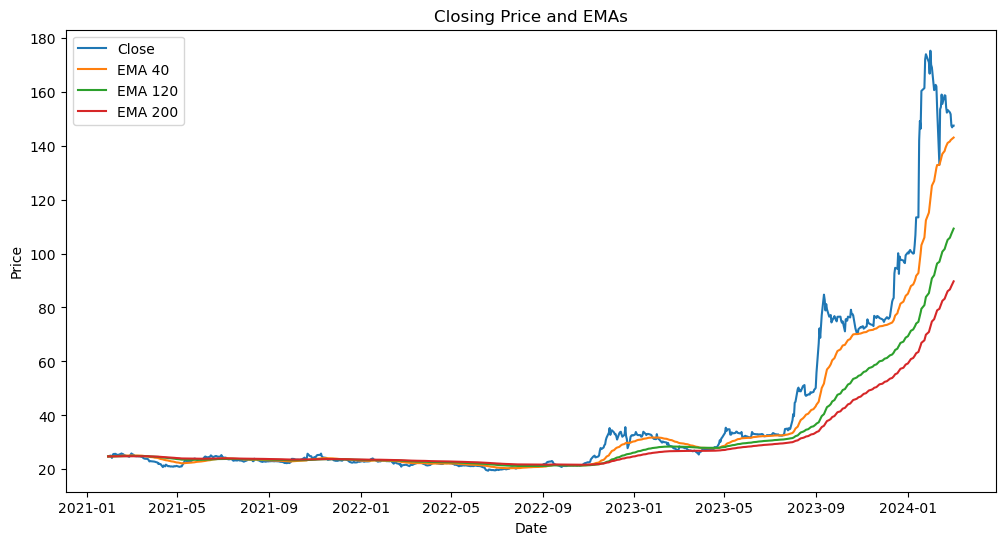

In [7]:
ticker = "IRFC.NS"
data = ydata(ticker)
# Call the function to analyze the EMAs
result = check_ema_trend(data)
print(result)

# Calculate EMAs
data['EMA_40'] = data['Close'].ewm(span=40, adjust=False).mean()
data['EMA_120'] = data['Close'].ewm(span=120, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close')
plt.plot(data['Date'], data['EMA_40'], label='EMA 40')
plt.plot(data['Date'], data['EMA_120'], label='EMA 120')
plt.plot(data['Date'], data['EMA_200'], label='EMA 200')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Price and EMAs')
plt.legend()
plt.show()

In [9]:
def check_price_consolidation(data):
    # Calculate 52-week high

    high_52_weeks = data.iloc['High'].rolling(window=200, min_periods=1).max()
    # high_52_weeks_last_20_days = data['High'].rolling(window=20, min_periods=1).max()
    # high_52_weeks.iloc[-20:] = high_52_weeks_last_20_days.iloc[-20:]
    
    # Calculate the range of 25% of the 52-week high
    twenty_five_percent_range = 0.30 * high_52_weeks
    
    # Calculate lower and upper bounds for consolidation box
    lower_bound = high_52_weeks - twenty_five_percent_range
    # upper_bound = high_52_weeks + twenty_five_percent_range
    upper_bound = high_52_weeks

    # Check for consolidation for at least 20 days within the range
    consolidation_mask = (data['High'] <= upper_bound) & (data['Low'] >= lower_bound)
    consolidated_days = consolidation_mask.rolling(window=15).sum() >= 15
    
    # Check for lower volume
    # lower_volume_mask = data['Volume'].rolling(window=20).mean() < data['Volume'].rolling(window=100).mean()
    
    # Check if the final candle is breaking out of the upper range with higher volume
    final_candle_breakout = (data['Close'] > upper_bound.shift(-1)) & (data['Volume'] > data['Volume'].rolling(window=2).mean())
    
    # return consolidated_days & lower_volume_mask & final_candle_breakout
    return consolidated_days  & final_candle_breakout

In [10]:
ticker = nifty500["yfin_ticker"].iloc[46]
data = ydata(ticker)
final_candle_breakout = check_price_consolidation(data)
df = pd.DataFrame(final_candle_breakout)
df[0].value_counts()
if len(df[df[0] == "True"]) > 0 :
    print("ticker")

[*********************100%***********************]  1 of 1 completed


TypeError: Cannot index by location index with a non-integer key

In [11]:
# Calculate 52-week high
high_52_weeks = data['High'].rolling(window=200, min_periods=1).max()

# Calculate the range of 25% of the 52-week high
twenty_five_percent_range = 0.20 * high_52_weeks

# Calculate lower and upper bounds for consolidation box
lower_bound = high_52_weeks - twenty_five_percent_range
# upper_bound = high_52_weeks + twenty_five_percent_range
upper_bound = high_52_weeks

# Check for consolidation for at least 20 days within the range
consolidation_mask = (data['High'] <= upper_bound) & (data['Low'] >= lower_bound)
consolidated_days = consolidation_mask.rolling(window=20).sum() >= 20

# Check for lower volume
# lower_volume_mask = data['Volume'].rolling(window=20).mean() < data['Volume'].rolling(window=100).mean()

# Check if the final candle is breaking out of the upper range with higher volume
final_candle_breakout = (data['Close'] > upper_bound.shift(-1)) & (data['Volume'] > data['Volume'].rolling(window=2).mean())


In [12]:
data["consolidated_days"] = consolidated_days

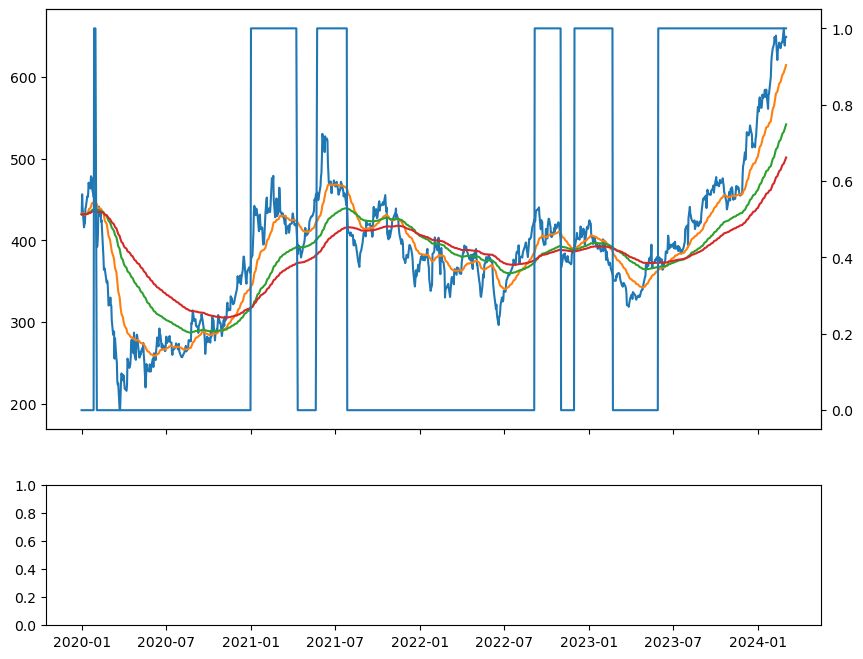

In [13]:
# Calculate EMAs
data['EMA_40'] = data['Close'].ewm(span=40, adjust=False).mean()
data['EMA_120'] = data['Close'].ewm(span=120, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Plot the data
# Plot candlestick chart with volume bars
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(data['Date'], data['Close'], label='Close')
ax1.plot(data['Date'], data['EMA_40'], label='EMA 40')
ax1.plot(data['Date'], data['EMA_120'], label='EMA 120')
ax1.plot(data['Date'], data['EMA_200'], label='EMA 200')
# Create a secondary y-axis for 'EPS'
ax2 = ax1.twinx()
ax2.plot(consolidated_days)
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Closing Price and EMAs')
# plt.legend()
plt.show()

In [ ]:
for i in range(len(nifty500)):
    ticker = nifty500["yfin_ticker"].iloc[i]
    data = ydata(ticker)
    final_candle_breakout = check_price_consolidation(data)
    df = pd.DataFrame(final_candle_breakout)
    df[0].value_counts()
    if len(df[df[0] == "True"]) > 0 :
        print("ticker")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
import pandas as pd
from datetime import timedelta

def check_condition(data):
    # Calculate daily max close in the last 200 days
    data['Max_200'] = data['Close'].rolling(window=200).max()

    # Calculate daily max close in the last 30 days
    data['Max_30'] = data['Close'].rolling(window=30).max()

    # Calculate thirty days ago
    thirty_days_ago = data['Date'] - timedelta(days=30)

    # Merge thirty days ago max close in the last 200 days with current dataframe
    data = pd.merge_asof(data.sort_values('Date'), data[['Date', 'Max_200']], 
                         left_on='Date', right_on='Date', direction='backward', suffixes=('', '_30_days_ago'))

    # Calculate daily SMA volume in the last 50 days
    data['SMA_Volume_50'] = data['Volume'].rolling(window=50).mean()

    # Check conditions
    condition = (data['Close'] * 1.05 > data['Max_200']) & \
                (data['Max_30'] <= data['Max_200_30_days_ago']) & \
                (data['Volume'] > data['SMA_Volume_50']) & \
                (data['Close'] > 90)

    return condition





[*********************100%***********************]  1 of 1 completed


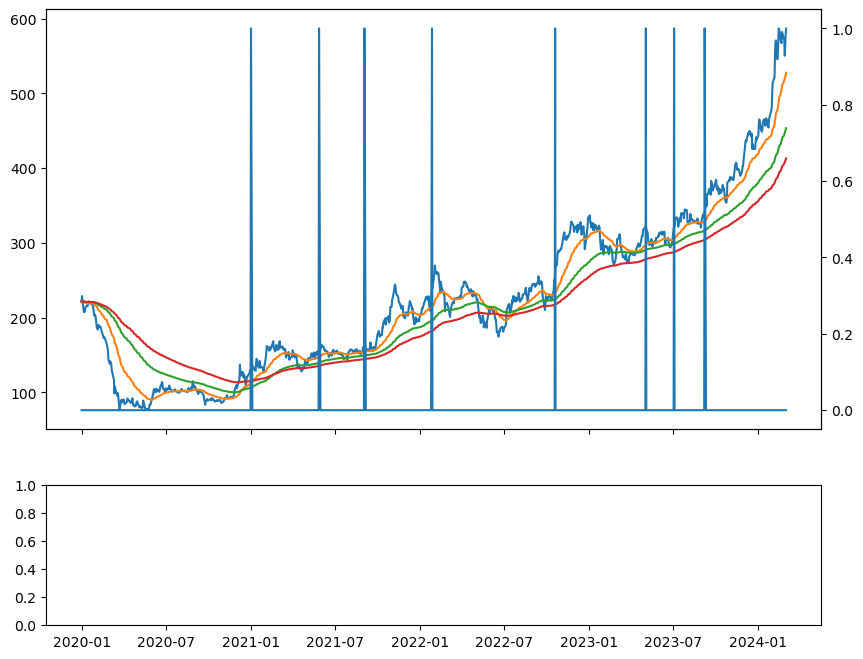

In [10]:
ticker = "CANBK.NS"
data = ydata(ticker)
data['Max_200'] = data['Close'].rolling(window=200).max()

# Calculate daily max close in the last 30 days
data['Max_30'] = data['Close'].rolling(window=30).max()

# Calculate thirty days ago
thirty_days_ago = data['Date'] - timedelta(days=30)

# Merge thirty days ago max close in the last 200 days with current dataframe
data = pd.merge_asof(data.sort_values('Date'), data[['Date', 'Max_200']], 
                        left_on='Date', right_on='Date', direction='backward', suffixes=('', '_30_days_ago'))

# Calculate daily SMA volume in the last 50 days
data['SMA_Volume_10'] = data['Volume'].rolling(window=10).mean()

# Shift the Max_200_days column by 30 days to compare with the Max_30_days 30 days ago
data['Max_200_days_shifted'] = data['Max_200'].shift(30)

# Check conditions
condition = (data['Close'] * 1.05 > data['Max_200']) & \
            (data['Max_30'] <= data['Max_200']) & \
            (data['Volume'] > data['SMA_Volume_10']) & \
            (data['Close'] > 90)

# Check if condition is not true for past fifteen days using rolling window
condition_past_15_days = condition.rolling(window=5).sum() == 0

# Combine the conditions
final_condition = condition & condition_past_15_days

# Add final condition as a column to the DataFrame
data['Final_Condition'] = final_condition.astype(int)
# Check conditions
data["condition"] = (data['Close'] * 1.05 > data['Max_200']) & \
            (data['Max_30'] <= data['Max_200_days_shifted']) & \
            (data['Volume'] > data['SMA_Volume_10']) & \
            (data['Close'] > 10)

data["condition_past_15_days"] = data["condition"].rolling(window=30).sum() == 1

data["final_condition"] = data["condition"] & data["condition_past_15_days"]
# data["final_condition"] = data["condition"] 
data[(data["condition"] == True) & (data["Date"] == "2023-08-22")]

# Calculate EMAs
data['EMA_40'] = data['Close'].ewm(span=40, adjust=False).mean()
data['EMA_120'] = data['Close'].ewm(span=120, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Plot the data
# Plot candlestick chart with volume bars
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(data['Date'], data['Close'], label='Close')
ax1.plot(data['Date'], data['EMA_40'], label='EMA 40')
ax1.plot(data['Date'], data['EMA_120'], label='EMA 120')
ax1.plot(data['Date'], data['EMA_200'], label='EMA 200')
# Create a secondary y-axis for 'EPS'
ax2 = ax1.twinx()
# ax2.plot(data['Date'], data['condition_past_15_days'],)
ax2.plot(data['Date'], data['final_condition'],)
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Closing Price and EMAs')
# plt.legend()
plt.show()

In [53]:
data[data["final_condition"] == True]

,Date,Open,High,Low,Close,Volume,Max_200,Max_30,Max_200_30_days_ago,SMA_Volume_10,Max_200_days_shifted,Final_Condition,condition,condition_past_15_days,final_condition,EMA_40,EMA_120,EMA_200,pivot
251,2021-01-01,128.899994,134.449997,128.000000,133.300003,33056834,137.000000,137.000000,137.000000,29917592.9,202.649994,0,True,True,True,113.382422,106.948754,115.238187,0
349,2021-05-28,156.100006,162.899994,154.800003,161.899994,60544144,168.550003,161.899994,168.550003,33485275.8,168.550003,0,True,True,True,147.381410,139.743329,135.540278,0
417,2021-09-03,159.350006,163.449997,159.100006,160.699997,19159144,168.550003,161.050003,168.550003,18766787.5,168.550003,0,True,True,True,154.309494,149.385141,144.616107,0
516,2022-01-27,218.000000,242.250000,216.000000,240.800003,46941087,244.250000,240.800003,244.250000,12606350.2,244.250000,0,True,True,True,213.921653,195.799936,182.109314,0
697,2022-10-20,247.949997,260.299988,238.600006,258.899994,47096087,269.649994,258.899994,269.649994,13545131.6,269.649994,0,True,True,True,233.262785,224.834569,217.571375,0
828,2023-05-04,320.500000,324.450012,317.000000,323.850006,5935785,336.799988,323.850006,336.799988,5541312.3,336.799988,0,True,True,True,298.207490,290.809914,278.128622,0
870,2023-07-04,320.700012,325.700012,317.549988,321.649994,14042359,336.799988,321.649994,336.799988,7090457.2,336.799988,0,True,True,True,304.879047,298.297538,287.566990,0
917,2023-09-08,339.000000,343.500000,335.500000,339.100006,7260594,344.799988,344.350006,344.799988,5694652.2,344.799988,0,True,True,True,329.404254,316.667739,304.288355,0


In [52]:
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.Low[l]>df1.Low[i]):
            pividlow=0
        if(df1.High[l]<df1.High[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0
    
data['pivot'] = data.apply(lambda x: pivotid(data, x.name,3,3), axis=1)

In [54]:
data['pivot'].value_counts()

0    825
1    109
2    100
3      2
Name: pivot, dtype: int64

In [20]:
nifty500 = pd.read_csv(r"C:\Users\MLAKSHMI\Pyworks\Trading\nifty500.csv")

In [21]:
nifty500 = nifty500[~(nifty500["yfin_ticker"].isin(["AMARAJABAT.NS","ADANITRANS.NS"]))]

In [83]:
nifty5001 = nifty500[nifty500["yfin_ticker"].isin(["IDFC.NS"])]

In [132]:

total_profit = 0
profit_count = 0
loss_count = 0
total_profit_percentage = 0
symbol_list = []
for i in range(len(nifty500)):

    symboltoken = str(nifty500["symboltoken"].iloc[i])
    symbol = str(nifty500["symbol"].iloc[i])
    ticker = str(nifty500["yfin_ticker"].iloc[i])

    try:
        data = ydata(ticker)
        if len(data) == 0:
            print(f"No data available for {ticker}, moving to next iteration.")
            continue  # Move to the next iteration
        # Process the data here
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        continue
    
    data['Max_200'] = data['Close'].rolling(window=200).max()

    # Calculate daily max close in the last 30 days
    data['Max_30'] = data['Close'].rolling(window=30).max()

    # Calculate thirty days ago
    thirty_days_ago = data['Date'] - timedelta(days=30)

    # Merge thirty days ago max close in the last 200 days with current dataframe
    data = pd.merge_asof(data.sort_values('Date'), data[['Date', 'Max_200']], 
                            left_on='Date', right_on='Date', direction='backward', suffixes=('', '_30_days_ago'))

    # Calculate daily SMA volume in the last 50 days
    data['SMA_Volume_10'] = data['Volume'].rolling(window=10).mean()

    # Shift the Max_200_days column by 30 days to compare with the Max_30_days 30 days ago
    data['Max_200_days_shifted'] = data['Max_200'].shift(30)

    # Check conditions
    condition = (data['Close'] * 1.05 > data['Max_200']) & \
                (data['Max_30'] <= data['Max_200']) & \
                (data['Volume'] > data['SMA_Volume_10']) & \
                (data['Close'] > 90)

    # Check if condition is not true for past fifteen days using rolling window
    condition_past_15_days = condition.rolling(window=5).sum() == 0

    # Combine the conditions
    final_condition = condition & condition_past_15_days

    # Add final condition as a column to the DataFrame
    data['Final_Condition'] = final_condition.astype(int)
    # Check conditions
    data["condition"] = (data['Close'] * 1.05 > data['Max_200']) & \
                (data['Max_30'] <= data['Max_200_days_shifted']) & \
                (data['Volume'] > data['SMA_Volume_10']) & \
                (data['Close'] > 10)

    data["condition_past_15_days"] = data["condition"].rolling(window=30).sum() == 1

    data["final_condition"] = data["condition"] & data["condition_past_15_days"]

    def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
        if l-n1 < 0 or l+n2 >= len(df1):
            return 0
        
        pividlow=1
        pividhigh=1
        for i in range(l-n1, l+n2+1):
            if(df1.Low[l]>df1.Low[i]):
                pividlow=0
            if(df1.High[l]<df1.High[i]):
                pividhigh=0
        if pividlow and pividhigh:
            return 3
        elif pividlow:
            return 1
        elif pividhigh:
            return 2
        else:
            return 0
        
    data['pivot'] = data.apply(lambda x: pivotid(data, x.name,3,3), axis=1)
    
    def pointpos(x):
        if x['pivot']==1:
            return x['Low']-1e-3
        elif x['pivot']==2:
            return x['High']+1e-3
        else:
            return np.nan

    data['pointpos'] = data.apply(lambda row: pointpos(row), axis=1)
    # Initialize trade variables and counters
    entry_price = None
    stop_loss = None
    profit_target = None


    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        if row['final_condition'] == 1:  # Entry condition met
            entry_price = row['High']
            stop_loss_candidate = None
            
            # Find the low of the last candle with data['pivot'] as 1 and low less than the low of the current candle
            for i in range(index - 1, -1, -1):  # Iterate backwards through the DataFrame
                if data.at[i, 'pivot'] == 1 and data.at[i, 'Low'] < row['Low']:
                    stop_loss_candidate = data.at[i, 'Low']
                    break
            
            # If a stop loss candidate is found, set stop_loss to it, otherwise use current row's low
            stop_loss = stop_loss_candidate if stop_loss_candidate is not None else row['Low']
            
            profit_target = entry_price + 1 * (entry_price - stop_loss)  # 10 times the stop loss
            print(entry_price, stop_loss,profit_target )
        elif entry_price is not None:  # Check for exit conditions
            if row['Low'] <= stop_loss:  # Stop loss hit
                loss = entry_price - stop_loss
                # print("loss", loss)
                total_profit -= loss
                total_profit_percentage -= (loss / entry_price) * 100
                entry_price = None
                loss_count += 1
            elif row['High'] >= profit_target:  # Profit target hit
                profit = profit_target - entry_price
                # print("profit", profit)
                total_profit += profit
                total_profit_percentage += (profit / entry_price) * 100
                entry_price = None
                profit_count += 1

# Output total profit, total profit percentage, profit count, and loss count
print("Total Profit:", total_profit)
print("Total Profit Percentage:", total_profit_percentage)
print("Profitable Trades:", profit_count)
print("Losing Trades:", loss_count)




[*********************100%***********************]  1 of 1 completed
286.25 247.46249389648438 325.0375061035156
322.5 277.75 367.25
437.5 355.98748779296875 519.0125122070312
456.25 412.54998779296875 499.95001220703125
470.36248779296875 437.5375061035156 503.1874694824219
482.6000061035156 417.3500061035156 547.8500061035156
512.0499877929688 501.0 523.0999755859375
698.0 597.25 798.75
[*********************100%***********************]  1 of 1 completed
23100.0 20837.30078125 25362.69921875
22500.0 20866.44921875 24133.55078125
24648.0 22291.0 27005.0
24600.0 23001.0 26199.0
31788.0 28870.0 34706.0
[*********************100%***********************]  1 of 1 completed
1186.800048828125 1011.5 1362.10009765625
1759.949951171875 1618.050048828125 1901.849853515625
1864.0 1800.0 1928.0
2359.699951171875 2000.0 2719.39990234375
3283.0 2945.0 3621.0
3319.699951171875 3053.10009765625 3586.2998046875
4465.0 4195.5498046875 4734.4501953125
[*********************100%***********************]  

In [27]:
today

datetime.datetime(2024, 3, 3, 21, 23, 56, 219253)

In [26]:
last_week_start

datetime.datetime(2024, 2, 19, 21, 23, 56, 219253)

In [32]:
today - timedelta(days=today.weekday() + 1)

datetime.datetime(2024, 2, 25, 21, 23, 56, 219253)

In [33]:
today = datetime.now()

# Calculate the start date of the last week
last_week_start = today - timedelta(days=today.weekday() + 1)
for i in range(len(nifty500)):

    symboltoken = str(nifty500["symboltoken"].iloc[i])
    symbol = str(nifty500["symbol"].iloc[i])
    ticker = str(nifty500["yfin_ticker"].iloc[i])

    try:
        data = ydata(ticker)
        if len(data) == 0:
            print(f"No data available for {ticker}, moving to next iteration.")
            continue  # Move to the next iteration
        # Process the data here
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        continue
    
    data['Max_200'] = data['Close'].rolling(window=200).max()

    # Calculate daily max close in the last 30 days
    data['Max_30'] = data['Close'].rolling(window=30).max()

    # Calculate thirty days ago
    thirty_days_ago = data['Date'] - timedelta(days=30)

    # Merge thirty days ago max close in the last 200 days with current dataframe
    data = pd.merge_asof(data.sort_values('Date'), data[['Date', 'Max_200']], 
                            left_on='Date', right_on='Date', direction='backward', suffixes=('', '_30_days_ago'))

    # Calculate daily SMA volume in the last 50 days
    data['SMA_Volume_10'] = data['Volume'].rolling(window=10).mean()

    # Shift the Max_200_days column by 30 days to compare with the Max_30_days 30 days ago
    data['Max_200_days_shifted'] = data['Max_200'].shift(30)

    # Check conditions
    condition = (data['Close'] * 1.05 > data['Max_200']) & \
                (data['Max_30'] <= data['Max_200']) & \
                (data['Volume'] > data['SMA_Volume_10']) & \
                (data['Close'] > 90)

    # Check if condition is not true for past fifteen days using rolling window
    condition_past_15_days = condition.rolling(window=5).sum() == 0

    # Combine the conditions
    final_condition = condition & condition_past_15_days

    # Add final condition as a column to the DataFrame
    data['Final_Condition'] = final_condition.astype(int)
    # Check conditions
    data["condition"] = (data['Close'] * 1.05 > data['Max_200']) & \
                (data['Max_30'] <= data['Max_200_days_shifted']) & \
                (data['Volume'] > data['SMA_Volume_10']) & \
                (data['Close'] > 10)

    data["condition_past_15_days"] = data["condition"].rolling(window=30).sum() == 1

    data["final_condition"] = data["condition"] & data["condition_past_15_days"]


    if len(data[data["final_condition"] == True]) > 0:
        
        xdate = data[data["final_condition"] == True]["Date"].iloc[-1]

        # Check if x falls within the last week
        if last_week_start <= xdate <= today:
            print(data[data["final_condition"] == True])
            print(symbol)
            print(data[data["final_condition"] == True].iloc[-1])

        


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [34]:
watchlist = ["AJANTPHARM-EQ", "KEI-EQ", "LODHA-EQ", "MAHLOG-EQ", "PATANJALI-BE", "PIDILITIND-EQ", "TATACOMM-EQ", "ULTRACEMCO-EQ"]

In [42]:
nifty5001 = nifty500[nifty500["symbol"].isin(watchlist)]

In [43]:
nifty5001

,Company Name,Industry,Symbol,Series,ISIN Code,symbol,symboltoken,yfin_ticker
23,Ajanta Pharmaceuticals Ltd.,Healthcare,AJANTPHARM,EQ,INE031B01049,AJANTPHARM-EQ,8124,AJANTPHARM.NS
265,KEI Industries Ltd.,Capital Goods,KEI,EQ,INE878B01027,KEI-EQ,13310,KEI.NS
298,Macrotech Developers Ltd.,Realty,LODHA,EQ,INE670K01029,LODHA-EQ,3220,LODHA.NS
305,Mahindra Logistics Ltd.,Services,MAHLOG,EQ,INE766P01016,MAHLOG-EQ,385,MAHLOG.NS
353,Patanjali Foods Ltd.,Fast Moving Consumer Goods,PATANJALI,BE,INE619A01035,PATANJALI-BE,17030,PATANJALI.NS
358,Pidilite Industries Ltd.,Chemicals,PIDILITIND,EQ,INE318A01026,PIDILITIND-EQ,2664,PIDILITIND.NS
440,Tata Communications Ltd.,Telecommunication,TATACOMM,EQ,INE151A01013,TATACOMM-EQ,3721,TATACOMM.NS
471,UltraTech Cement Ltd.,Construction Materials,ULTRACEMCO,EQ,INE481G01011,ULTRACEMCO-EQ,11532,ULTRACEMCO.NS


In [47]:
for i in range(len(nifty5001)):

    symboltoken = str(nifty5001["symboltoken"].iloc[i])
    symbol = str(nifty5001["symbol"].iloc[i])
    ticker = str(nifty5001["yfin_ticker"].iloc[i])

    try:
        data = ydata(ticker)
        if len(data) == 0:
            print(f"No data available for {ticker}, moving to next iteration.")
            continue  # Move to the next iteration
        # Process the data here
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        continue
    
    data['Max_200'] = data['Close'].rolling(window=200).max()

    # Calculate daily max close in the last 30 days
    data['Max_30'] = data['Close'].rolling(window=30).max()

    # Calculate thirty days ago
    thirty_days_ago = data['Date'] - timedelta(days=30)

    # Merge thirty days ago max close in the last 200 days with current dataframe
    data = pd.merge_asof(data.sort_values('Date'), data[['Date', 'Max_200']], 
                            left_on='Date', right_on='Date', direction='backward', suffixes=('', '_30_days_ago'))

    # Calculate daily SMA volume in the last 50 days
    data['SMA_Volume_10'] = data['Volume'].rolling(window=10).mean()

    # Shift the Max_200_days column by 30 days to compare with the Max_30_days 30 days ago
    data['Max_200_days_shifted'] = data['Max_200'].shift(30)

    # Check conditions
    condition = (data['Close'] * 1.05 > data['Max_200']) & \
                (data['Max_30'] <= data['Max_200']) & \
                (data['Volume'] > data['SMA_Volume_10']) & \
                (data['Close'] > 90)

    # Check if condition is not true for past fifteen days using rolling window
    condition_past_15_days = condition.rolling(window=5).sum() == 0

    # Combine the conditions
    final_condition = condition & condition_past_15_days

    # Add final condition as a column to the DataFrame
    data['Final_Condition'] = final_condition.astype(int)
    # Check conditions
    data["condition"] = (data['Close'] * 1.05 > data['Max_200']) & \
                (data['Max_30'] <= data['Max_200_days_shifted']) & \
                (data['Volume'] > data['SMA_Volume_10']) & \
                (data['Close'] > 10)

    data["condition_past_15_days"] = data["condition"].rolling(window=30).sum() == 1

    data["final_condition"] = data["condition"] & data["condition_past_15_days"]
    
    def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
        if l-n1 < 0 or l+n2 >= len(df1):
            return 0
        
        pividlow=1
        pividhigh=1
        for i in range(l-n1, l+n2+1):
            if(df1.Low[l]>df1.Low[i]):
                pividlow=0
            if(df1.High[l]<df1.High[i]):
                pividhigh=0
        if pividlow and pividhigh:
            return 3
        elif pividlow:
            return 1
        elif pividhigh:
            return 2
        else:
            return 0
        
    data['pivot'] = data.apply(lambda x: pivotid(data, x.name,3,3), axis=1)
    
    def pointpos(x):
        if x['pivot']==1:
            return x['Low']-1e-3
        elif x['pivot']==2:
            return x['High']+1e-3
        else:
            return np.nan

    data['pointpos'] = data.apply(lambda row: pointpos(row), axis=1)

    data.set_index("Date", inplace=True)
    # Create subplots with a larger figure size
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.6, 0.2, 0.2], print_grid=False, specs=[[{"secondary_y": True}],[{"secondary_y": False}],[{"secondary_y": False}]])

    # Add Candlestick chart
    fig.add_trace(go.Candlestick(x=data.index,
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close'], name="Candlestick"), row=1, col=1)

    # # Add scatter points for pivots
    # fig.add_trace(go.Line(x=data.index, y=data['EMA_40']), row=1, col=1)
    # fig.add_trace(go.Line(x=data.index, y=data['EMA_40']), row=1, col=1)
    # fig.add_trace(go.Scatter(x=df1.index[final_ind_pivot_low], y=df1['Low'][final_ind_pivot_low], mode='markers', marker=dict(color='red', symbol='triangle-down', size=10), name='Low Pivot'), row=1, col=1)

    # # Add Swing chart
    # fig.add_trace(go.Scatter(x=merged_swing_df.index, y=merged_swing_df['SwingValue'], mode='lines', line=dict(color='blue'), name='Swing Value'), row=1, col=1)

    # Add EPS line chart
    fig.add_trace(go.Scatter(x=data.index, y=data['final_condition'], mode='lines', line=dict(color='purple'), name='EPS'), row=1, col=1, secondary_y=True)

    # Add Volume bars
    fig.add_trace(go.Bar(x=data.index, y=data['Volume'], marker=dict(color='blue'), name='Volume'), row=2, col=1)
    fig.add_scatter(x=data.index, y=data['pointpos'], mode="markers",
                    marker=dict(size=5, color="MediumPurple"),
                    name="pivot")
    # Update axes labels and title
    # fig.update_xaxes(title_text='Date', row=3, col=1)
    fig.update_yaxes(title_text='Price', row=1, col=1, secondary_y=False)
    fig.update_yaxes(title_text='EPS', row=1, col=1, secondary_y=True)
    fig.update_yaxes(title_text='Volume', row=2, col=1)

    # Update layout to increase the figure size
    fig.update_layout(title_text=symbol, xaxis_rangeslider_visible=False, height=1200, width=1000)

    # Show the plot
    fig.show()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [105]:
import statsmodels.api as sm
from datetime import datetime, timedelta

In [106]:
data[data["final_condition"] == True]

,Date,Open,High,Low,Close,Volume,Max_200,Max_30,Max_200_30_days_ago,SMA_Volume_10,Max_200_days_shifted,Final_Condition,condition,condition_past_15_days,final_condition,pivot,pointpos
275,2021-02-05,276.750000,286.250000,266.975006,282.625000,1221784,286.387512,282.625000,286.387512,203539.2,365.087494,0,True,True,True,0,NaN
382,2021-07-14,311.250000,322.500000,307.375000,318.237488,323732,328.287506,318.237488,328.287506,157158.8,328.287506,0,True,True,True,0,NaN
560,2022-04-01,435.000000,437.500000,420.000000,424.475006,3422656,441.587494,424.475006,441.587494,869420.8,441.587494,0,True,True,True,0,NaN
668,2022-09-08,431.887512,456.250000,431.687500,448.712494,361856,464.137512,448.712494,464.137512,153175.2,464.137512,0,True,True,True,2,456.251
733,2022-12-13,443.662506,470.362488,442.524994,453.912506,13089680,473.700012,466.262512,473.700012,2191876.0,473.700012,0,True,True,True,0,NaN
871,2023-07-05,482.600006,482.600006,471.100006,474.899994,440459,487.524994,482.149994,487.524994,398586.7,487.524994,0,True,True,True,0,NaN
910,2023-08-30,511.000000,512.049988,502.000000,505.350006,310987,523.750000,521.650024,523.750000,205894.1,523.750000,0,True,True,True,0,NaN
1021,2024-02-13,650.750000,698.000000,647.049988,691.700012,1283704,709.849976,702.849976,709.849976,661840.2,709.849976,0,True,True,True,0,NaN


In [124]:
# Filter data for the last 6 months
six_months_ago = datetime.now() - timedelta(days=180)
x = 668
data_last_20days = data[x-20:x]
data
# Perform regression analysis
def calculate_slope(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    return results.params[1]
# Calculate slope for each EMA
slope_40 = calculate_slope(np.arange(len(data_last_20days)), data_last_20days['Close'])
slope_40

0.4965503893400589

In [125]:
data_last_20days

,Date,Open,High,Low,Close,Volume,Max_200,Max_30,Max_200_30_days_ago,SMA_Volume_10,Max_200_days_shifted,Final_Condition,condition,condition_past_15_days,final_condition,pivot,pointpos
648,2022-08-08,414.274994,414.750000,409.062500,410.537506,130616,464.137512,420.375000,464.137512,144778.0,464.137512,0,False,False,False,0,NaN
649,2022-08-10,412.500000,415.762512,405.549988,414.225006,53888,464.137512,420.375000,464.137512,142866.8,464.137512,0,False,False,False,1,405.548988
650,2022-08-11,407.000000,417.500000,407.000000,414.037506,52688,464.137512,420.375000,464.137512,136366.8,464.137512,0,False,False,False,0,NaN
651,2022-08-12,407.825012,415.000000,407.825012,414.149994,49844,464.137512,420.375000,464.137512,132513.6,464.137512,0,False,False,False,0,NaN
652,2022-08-16,414.575012,420.000000,410.274994,414.899994,96568,464.137512,420.375000,464.137512,113690.0,464.137512,0,False,False,False,0,NaN
653,2022-08-17,415.325012,418.750000,410.625000,414.725006,77536,464.137512,420.375000,464.137512,106446.4,464.137512,0,False,False,False,0,NaN
654,2022-08-18,410.750000,418.750000,410.750000,418.075012,37540,464.137512,420.375000,464.137512,86168.0,464.137512,0,False,False,False,0,NaN
655,2022-08-19,416.912506,426.087494,416.899994,420.937500,215500,464.137512,420.937500,464.137512,85746.8,464.137512,0,False,False,False,0,NaN
656,2022-08-22,425.250000,425.250000,417.674988,419.887512,43844,464.137512,420.937500,464.137512,80900.4,464.137512,0,False,False,False,0,NaN
657,2022-08-23,417.812500,427.500000,417.387512,419.537506,81560,464.137512,420.937500,464.137512,83958.4,464.137512,0,False,False,False,2,427.501000
